#### Multiple tools integration

In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper


In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

In [3]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

In [5]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [7]:
from langchain_tavily import TavilySearch

tavily = TavilySearch()

In [8]:
tools = [wiki,arxiv,tavily]

In [9]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="Gemma2-9b-It")

In [10]:
llm_with_tools = llm.bind_tools(tools)

Creating Graph

In [13]:
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_core.messages import AIMessage,HumanMessage,AnyMessage


class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]


In [14]:
def llm_agent(state:State):
    return {"messages":llm_with_tools.invoke(state["messages"])}

In [15]:
graph_builder = StateGraph(State)

graph_builder.add_node("llm_agent",llm_agent)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.add_edge(START,"llm_agent")
graph_builder.add_conditional_edges("llm_agent",tools_condition)
graph_builder.add_edge("tools",END)


graph = graph_builder.compile()

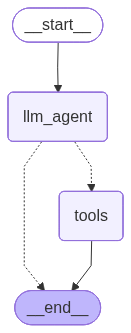

In [16]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

ArXiv Tool in action 

In [17]:
messages = graph.invoke({"messages":"What's the paper 1605.08386 about?"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What's the paper 1605.08386 about?
================================== Ai Message ==================================
Tool Calls:
  arxiv (fn5yxn30s)
 Call ID: fn5yxn30s
  Args:
    query: 1605.08386
================================= Tool Message =================================
Name: arxiv

Published: 2016-05-26
Title: Heat-bath random walks with Markov bases
Authors: Caprice Stanley, Tobias Windisch
Summary: Graphs on lattice points are studied whose edges come from a finite set of
allowed moves of arbitrary length. We show that the diameter of these graphs on
fibers of a fixed integer matrix can be bounded from above by a constant. We
then study the mixing behaviour of heat-bath random walks on these graphs. We
also state explicit conditions on the set of moves so that the heat-b


Wiki in action

In [18]:
messages = graph.invoke({"messages":"what is Machine Learning?"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is Machine Learning?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (wtbjgbebj)
 Call ID: wtbjgbebj
  Args:
    query: Machine Learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi


Tavily in Action

In [20]:
messages = graph.invoke({"messages":"search latest telugu movies released in august month?"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

search latest telugu movies released in august month?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (kd2n1d2m8)
 Call ID: kd2n1d2m8
  Args:
    query: latest telugu movies released in august month
    time_range: month
================================= Tool Message =================================
Name: tavily_search

{"query": "latest telugu movies released in august month", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.gadgets360.com/entertainment/new-telugu-movies", "title": "New Telugu Movies | List of Latest Telugu Movies Releases 2025", "content": "Paradha · Anupama Parameswaran Darshana Rajendran, Sangeetha, Rag Mayur · Release Date. 22 August 2025 · Drama · Director Praveen Kandregula · Users Rating. (2.5/5)", "score": 0.8568246, "raw_content": null}, {"url": "https://www.siasat.com/list-o